In [1]:
!pip install h2o requests tabulate future -q

print("Installation done.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 5.7 MB/s eta 0:00:00
Installation done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.")
print(f"Python version: {pd.__version__}")

Libraries imported.
Python version: 2.2.2


In [3]:
from google.colab import files
print("Please upload your athletes.csv file:")
uploaded = files.upload()

athletes_pd = pd.read_csv('athletes.csv')

print(f"\n Data loaded.")
print(f"Shape: {athletes_pd.shape}")
print(f"Columns: {list(athletes_pd.columns)}")

athletes_pd.head()

Please upload your athletes.csv file:


Saving athletes.csv to athletes.csv

 Data loaded.
Shape: (423006, 27)
Columns: ['athlete_id', 'name', 'region', 'team', 'affiliate', 'gender', 'age', 'height', 'weight', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad', 'run400', 'run5k', 'candj', 'snatch', 'deadlift', 'backsq', 'pullups', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong']


,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [4]:
from sklearn.preprocessing import LabelEncoder

print(f"Dataset shape before cleaning: {athletes_pd.shape[0]} rows, {athletes_pd.shape[1]} columns")
print(f"Columns: {list(athletes_pd.columns)}")

print(f"Original Pandas DataFrame shape: {athletes_pd.shape}")

original_shape = athletes_pd.shape
original_size = len(athletes_pd)

print("1. Removing outliers.")

mask = pd.Series([True] * len(athletes_pd))

# weight outliers.
if 'weight' in athletes_pd.columns:
    mask = mask & (athletes_pd['weight'] < 1500)

# gender validation.
if 'gender' in athletes_pd.columns:
    mask = mask & (athletes_pd['gender'] != '--')

# age restriction.
if 'age' in athletes_pd.columns:
    mask = mask & (athletes_pd['age'] >= 18)

# height outliers.
if 'height' in athletes_pd.columns:
    mask = mask & ((athletes_pd['height'] < 96) & (athletes_pd['height'] > 48))

athletes_pd = athletes_pd[mask]
print(f"After demographic filtering: {len(athletes_pd)} rows.")

print("2. Removing lift performance outliers.")

# deadlift outliers.
if 'deadlift' in athletes_pd.columns and 'gender' in athletes_pd.columns:
    mask2 = (athletes_pd['deadlift'] > 0) & (athletes_pd['deadlift'] <= 1105)
    mask2 = mask2 | ((athletes_pd['gender'] == 'Female') & (athletes_pd['deadlift'] <= 636))
    athletes_pd = athletes_pd[mask2]

# clean and jerk outliers.
if 'candj' in athletes_pd.columns:
    athletes_pd = athletes_pd[(athletes_pd['candj'] > 0) & (athletes_pd['candj'] <= 395)]

#sSnatch outliers.
if 'snatch' in athletes_pd.columns:
    athletes_pd = athletes_pd[(athletes_pd['snatch'] > 0) & (athletes_pd['snatch'] <= 496)]

# back squat outliers.
if 'backsq' in athletes_pd.columns:
    athletes_pd = athletes_pd[(athletes_pd['backsq'] > 0) & (athletes_pd['backsq'] <= 1069)]

print(f"After lift filtering: {len(athletes_pd)} rows.")

print("3. Cleaning the survey data.")
decline_dict = {'Decline to answer': np.nan, 'Decline to answer|': np.nan}
athletes_pd = athletes_pd.replace(decline_dict)
print("Replaced with NaN.")

print("4. Dropping irrelevant columns.")
columns_to_drop = ['region', 'team', 'affiliate', 'name', 'eat',
                   'train', 'background', 'experience', 'schedule', 'howlong',
                   'fran', 'helen', 'grace', 'filthy50', 'fgonebad',
                   'run400', 'run5k', 'pullups']

existing_cols_to_drop = [col for col in columns_to_drop if col in athletes_pd.columns]
athletes_pd = athletes_pd.drop(columns=existing_cols_to_drop, errors='ignore')
print(f"Dropped {len(existing_cols_to_drop)} columns: {existing_cols_to_drop}")

print(f"After column removal: {athletes_pd.shape}")

print("5. Creating target variable as total_lift.")
athletes_pd['total_lift'] = athletes_pd['deadlift'] + athletes_pd['candj'] + athletes_pd['snatch'] + athletes_pd['backsq']
print(f"total_lift = deadlift + candj + snatch + backsq.")

athletes_pd = athletes_pd.dropna(subset=['total_lift'])
print(f"After removing rows with missing total_lift: {len(athletes_pd)} rows")

print("="*80)
print("Summary.")
print(f"Original shape: {original_shape}")
print(f"Final shape: {athletes_pd.shape}")
print(f"Rows removed: {original_shape[0] - athletes_pd.shape[0]}")
print(f"Columns removed: {original_shape[1] - athletes_pd.shape[1] + 1}")
print(f"Data retention: {(athletes_pd.shape[0] / original_shape[0]) * 100:.2f}%")

required_cols = ['deadlift', 'candj', 'snatch', 'backsq', 'total_lift']
missing_cols = [col for col in required_cols if col not in athletes_pd.columns]
if missing_cols:
    print(f"Missing required columns: {missing_cols}")
else:
    print(f"All required columns: {required_cols}")

print("First rows after cleaning:")
print(athletes_pd.head())

print(f"total_lift stats:")
print(athletes_pd['total_lift'].describe())

print("Missing values in remaining columns:")
missing_summary = athletes_pd.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    missing_df = pd.DataFrame({
        'Column': missing_summary.index,
        'Missing_Count': missing_summary.values,
        'Missing_Percentage': (missing_summary.values / len(athletes_pd) * 100).round(2)
    })
    print(missing_df)
    print("Remaining missing values can be handled with imputation during feature engineering.")
else:
    print("No missing values in any columns.")

target_col = 'total_lift'

automl_data = athletes_pd.copy()

cols_to_drop = ['athlete_id', 'Unnamed: 0']
automl_data = automl_data.drop(columns=[c for c in cols_to_drop if c in automl_data.columns], errors='ignore')

print(f"Preparing the data for H2O AutoML.")
print(f"Target variable: {target_col}")

# filling the missing values in the numeric variables.
numeric_cols = automl_data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col != target_col and automl_data[col].isna().sum() > 0:
        automl_data[col].fillna(automl_data[col].median(), inplace=True)
        print(f"Filled missing values in '{col}' with median.")

# encoding the categorical variables.
categorical_cols = automl_data.select_dtypes(include=['object']).columns.tolist()
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

if len(categorical_cols) > 0:
    print(f"\nEncoding categorical columns: {categorical_cols}")
    for col in categorical_cols:
        le = LabelEncoder()
        automl_data[col] = le.fit_transform(automl_data[col].astype(str))
        print(f"Encoded '{col}': {len(le.classes_)} unique values.")

print(f"Data prepared for AutoML.")
print(f"Final shape: {automl_data.shape}")
print(f"Target: {target_col}")
print(f"Features: {automl_data.shape[1] - 1}")
print(f"All numeric: {automl_data.select_dtypes(include=['object']).shape[1] == 0}")


Dataset shape before cleaning: 423006 rows, 27 columns
Columns: ['athlete_id', 'name', 'region', 'team', 'affiliate', 'gender', 'age', 'height', 'weight', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad', 'run400', 'run5k', 'candj', 'snatch', 'deadlift', 'backsq', 'pullups', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong']
Original Pandas DataFrame shape: (423006, 27)
1. Removing outliers.
After demographic filtering: 142219 rows.
2. Removing lift performance outliers.
After lift filtering: 70365 rows.
3. Cleaning the survey data.
Replaced with NaN.
4. Dropping irrelevant columns.
Dropped 18 columns: ['region', 'team', 'affiliate', 'name', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad', 'run400', 'run5k', 'pullups']
After column removal: (70365, 9)
5. Creating target variable as total_lift.
total_lift = deadlift + candj + snatch + backsq.
After removing rows with missing total_lift: 70365 rows
Summar

In [7]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(max_mem_size="4G")

print("H2O initialized.")
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.28" 2025-07-15; OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdf8suf5e
  JVM stdout: /tmp/tmpdf8suf5e/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdf8suf5e/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,"28 days, 5 hours and 15 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_0q8cvo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


H2O initialized.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,"28 days, 5 hours and 15 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_0q8cvo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [8]:
# converting the dataset to the H2O format and I'm using total_lift as the target variable.

target = 'total_lift'
features = [col for col in automl_data.columns if col != target]

print(f"\nTarget: {target}")
print(f"Features ({len(features)}): {features[:10] if len(features) > 10 else features}")

h2o_df = h2o.H2OFrame(automl_data)

# data types.
print(f"Target column type: {h2o_df[target].type}")
print(f"Target range: [{h2o_df[target].min()}, {h2o_df[target].max()}]")

train, valid, test = h2o_df.split_frame(ratios=[0.7, 0.15], seed=42)

print(f"Data split:")
print(f"  Training set: {train.shape}")
print(f"  Validation set: {valid.shape}")
print(f"  Test set: {test.shape}")

train_mean = train[target].mean()
valid_mean = valid[target].mean()
test_mean = test[target].mean()

print(f"\nTarget statistics:")
print(f"  Train target mean: {train_mean}")
print(f"  Valid target mean: {valid_mean}")
print(f"  Test target mean: {test_mean}")


Target: total_lift
Features (8): ['gender', 'age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq']
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Target column type: <bound method H2OFrame.type of H2OFrame({'_ex': <Expr(cols_py <Expr()#Key_Frame__upload_83d9c8d64c7d2148aff7eee0c42d4209.hex> 'total_lift'); scalar>})>
Target range: [4.0, 2367.0]
Data split:
  Training set: (49252, 9)
  Validation set: (10490, 9)
  Test set: (10623, 9)

Target statistics:
  Train target mean: [1002.9746609274715]
  Valid target mean: [999.1623450905574]
  Test target mean: [1001.8803539489794]


In [9]:
print("RUNNING H2O AutoML with all features.")

aml_all = H2OAutoML(
    max_models=20,
    max_runtime_secs=600,
    seed=42,
    stopping_metric="RMSE",
    stopping_tolerance=0.001,
    stopping_rounds=3,
    project_name="athletes_all_features",
    exclude_algos=["GLM"],
    verbosity="info",
    nfolds=5,
    keep_cross_validation_predictions=True
)


start_time = datetime.now()
aml_all.train(
    x=features,
    y=target,
    training_frame=train,
    validation_frame=valid
)
training_time_all = (datetime.now() - start_time).total_seconds()

print(f"AutoML completed in {training_time_all:.2f} seconds.")

lb_all = aml_all.leaderboard
print("Leaderboard (model with all features):")
lb_df = lb_all.as_data_frame()
print(lb_df.head(10))

# best model.
best_model = aml_all.leader
print(f"\n Best Model: {best_model.model_id}")

perf_test = best_model.model_performance(test)
print("\n Test set:")
print(f"  R2 Score: {perf_test.r2():.4f}")
print(f"  RMSE: {perf_test.rmse():.2f}")
print(f"  MAE: {perf_test.mae():.2f}")

RUNNING H2O AutoML with all features.
AutoML progress: |
20:40:16.997: Project: athletes_all_features
20:40:16.998: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
20:40:16.999: Stopping tolerance set by the user: 0.001
20:40:16.999: Stopping tolerance set by the user is < 70% of the recommended default of 0.004505967599794246, so models may take a long time to converge or may not converge at all.
20:40:16.999: Build control seed: 42
20:40:17.0: training frame: Frame key: AutoML_1_20251105_204016_training_py_4_sid_92c9    cols: 9    rows: 49252  chunks: 1    size: 696299  checksum: -12400033456070
20:40:17.0: validation frame: Frame key: py_5_sid_92c9    cols: 9    rows: 10490  chunks: 1    size: 148786  checksum: -5198893720220
20:40:17.1: leaderboard frame: NULL
20:40:17.1: ble

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



 Test set:
  R2 Score: 0.9994
  RMSE: 6.72
  MAE: 3.47


# run


In [12]:
print("Top 3 models by validation score with all features.")

lb_all_df = lb_all.as_data_frame()
print("Available columns in leaderboard:")
print(lb_all_df.columns.tolist())
print()

print(f"Total models before filtering: {len(lb_all_df)}")

lb_all_df_filtered = lb_all_df[~lb_all_df['model_id'].str.contains('GLM', na=False)]
print(f"Models after removing GLM: {len(lb_all_df_filtered)}")

# sorting by RMSE for the top 3 models.
lb_all_df_filtered = lb_all_df_filtered.sort_values('rmse')
top_3_all_df = lb_all_df_filtered.head(3)

print("Using top 3 non-GLM models.")
print()

top_3_models_all = []

for idx, row in top_3_all_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    # model type.
    model_type = model_id.split('_')[0]

    # performance from the test set.
    perf = model.model_performance(test)

    # training time.
    training_time_sec = 0
    if 'training_time_ms' in row:
        training_time_sec = row['training_time_ms'] / 1000
    elif 'training_time' in row:
        training_time_sec = row['training_time']
    else:
        for col in row.index:
            if 'time' in col.lower() and col != 'model_id':
                if 'ms' in col.lower():
                    training_time_sec = row[col] / 1000
                else:
                    training_time_sec = row[col]
                break

    model_info = {
        'model': model_type,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'mae': perf.mae(),
        'time_seconds': training_time_sec,
        'model_id': model_id
    }
    top_3_models_all.append(model_info)

    print(f"{len(top_3_models_all)}. {model_type}")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")
    print(f"   MAE: {model_info['mae']:.2f}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s")

Top 3 models by validation score with all features.
Available columns in leaderboard:
['model_id', 'rmse', 'mse', 'mae', 'rmsle', 'mean_residual_deviance']

Total models before filtering: 1
Models after removing GLM: 1
Using top 3 non-GLM models.



/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


1. XGBoost
   R2 Score: 0.9994
   RMSE: 6.72
   MAE: 3.47
   Training Time: 0.00s


In [13]:
print("Top 3 fastest models with all features.")

lb_all_df = lb_all.as_data_frame()

# finding the time column.
time_column = None
for col in lb_all_df.columns:
    if 'time' in col.lower():
        time_column = col
        break

if time_column:
    print(f"Sorting by: {time_column}")
    lb_all_by_speed = lb_all_df.sort_values(time_column)
else:
    print("No time column found, using default order.")
    lb_all_by_speed = lb_all_df

fastest_3_all_df = lb_all_by_speed.head(3)
fastest_3_models_all = []

for idx, row in fastest_3_all_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    model_type = model_id.split('_')[0]
    perf = model.model_performance(test)

    # training time.
    if time_column and time_column in row:
        if 'ms' in time_column.lower():
            time_sec = row[time_column] / 1000
        else:
            time_sec = row[time_column]
    else:
        time_sec = 0

    model_info = {
        'model': model_type,
        'time_seconds': time_sec,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'model_id': model_id
    }
    fastest_3_models_all.append(model_info)

    print(f"{idx+1}. {model_type}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s.")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")

Top 3 fastest models with all features.
No time column found, using default order.


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


1. XGBoost
   Training Time: 0.00s.
   R2 Score: 0.9994
   RMSE: 6.72


Feature importance (Top 5 features).
Top 5 Features:
1. backsq: 2818077696.0000
2. deadlift: 699831616.0000
3. candj: 664815488.0000
4. snatch: 175499392.0000
5. gender: 1251261.2500


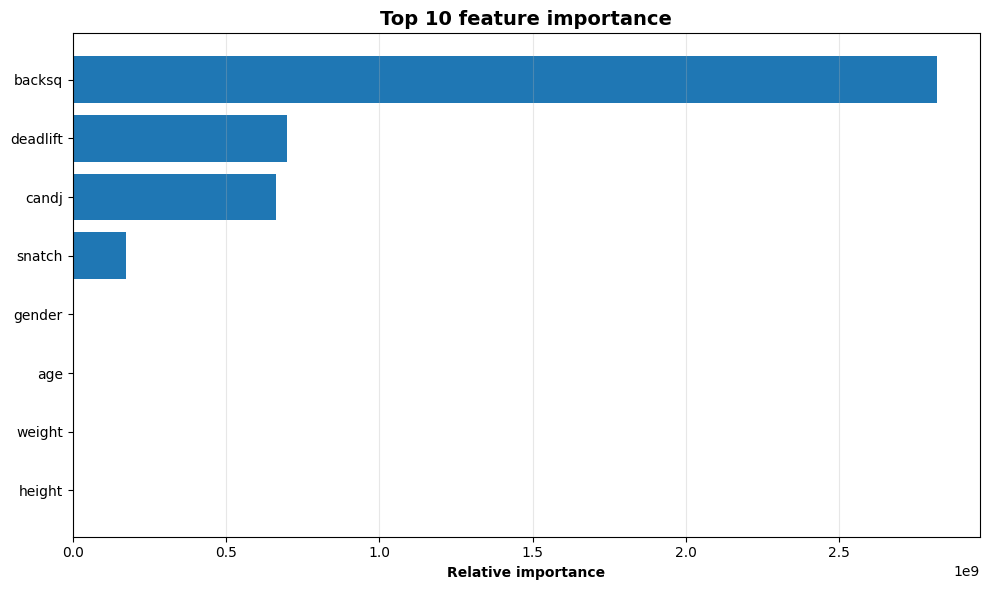

In [16]:
print("Feature importance (Top 5 features).")

# best model.
best_model = aml_all.leader

# variable importance.
varimp = best_model.varimp(use_pandas=True)

if varimp is not None:
    top_5_features = varimp.head(5)['variable'].tolist()

    print("Top 5 Features:")
    for i, row in varimp.head(5).iterrows():
        print(f"{i+1}. {row['variable']}: {row['relative_importance']:.4f}")

    plt.figure(figsize=(10, 6))
    top_10 = varimp.head(10)
    plt.barh(range(len(top_10)), top_10['relative_importance'])
    plt.yticks(range(len(top_10)), top_10['variable'])
    plt.xlabel('Relative importance', fontweight='bold')
    plt.title('Top 10 feature importance', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

In [17]:
print("H2O AutoML with the top 3 features only.")

top_3_features = top_5_features[:3]
print(f"Using features: {top_3_features}")

# AutoML for the top 3 features.
aml_top3 = H2OAutoML(
    max_models=20,
    max_runtime_secs=900,
    seed=42,
    sort_metric="RMSE",
    project_name="athletes_top3_features"
)

# training.
start_time = datetime.now()
aml_top3.train(x=top_3_features, y=target, training_frame=train)
training_time_top3 = (datetime.now() - start_time).total_seconds()

print(f"AutoML (top 3 features) completed in {training_time_top3:.2f} seconds.")

lb_top3 = aml_top3.leaderboard
print("Leaderboard (Top 3 features):")
print(lb_top3.head(rows=10))

H2O AutoML with the top 3 features only.
Using features: ['backsq', 'deadlift', 'candj']
AutoML progress: |
21:03:31.41: Empty leaderboard.
AutoML was not able to build any model within a max runtime constraint of 900 seconds, you may want to increase this value before retrying.
21:03:37.289: New models will be added to existing leaderboard athletes_top3_features@@total_lift (leaderboard frame=null) with already 0 models.

███████████████████████████████████████████████████████████████| (done) 100%
AutoML (top 3 features) completed in 902.01 seconds.
Leaderboard (Top 3 features):
model_id                                            rmse      mse      mae        rmsle    mean_residual_deviance
GLM_1_AutoML_3_20251105_210337                   15.5461  241.681  11.3802    0.021855                    241.681
DeepLearning_1_AutoML_3_20251105_210337          15.7679  248.626  11.4688    0.0390237                   248.626
GBM_5_AutoML_3_20251105_210337                   15.8362  250.785  11.3

In [18]:
print("Top 3 models by validation score (Top 3 features).")

top_3_top3_df = lb_top3.head(rows=3).as_data_frame()
top_3_models_top3 = []

for idx, row in top_3_top3_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    model_type = model_id.split('_')[0]
    perf = model.model_performance(test)

    training_time_sec = 0
    if 'training_time_ms' in row:
        training_time_sec = row['training_time_ms'] / 1000
    elif 'training_time' in row:
        training_time_sec = row['training_time']
    else:
        for col in row.index:
            if 'time' in col.lower():
                if 'ms' in col.lower():
                    training_time_sec = row[col] / 1000
                else:
                    training_time_sec = row[col]
                break

    model_info = {
        'model': model_type,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'mae': perf.mae(),
        'time_seconds': training_time_sec,
        'model_id': model_id
    }
    top_3_models_top3.append(model_info)

    print(f"{idx+1}. {model_type}")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")
    print(f"   MAE: {model_info['mae']:.2f}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s.")

Top 3 models by validation score (Top 3 features).
1. GLM
   R2 Score: 0.9970
   RMSE: 15.23
   MAE: 11.14
   Training Time: 0.00s.


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


2. DeepLearning
   R2 Score: 0.9969
   RMSE: 15.45
   MAE: 11.26
   Training Time: 0.00s.
3. GBM
   R2 Score: 0.9970
   RMSE: 15.29
   MAE: 11.17
   Training Time: 0.00s.


In [19]:
print("Top 3 fastest models (Top 3 features).")

# all models as dataframe.
lb_top3_df = lb_top3.as_data_frame()

time_column = None
for col in lb_top3_df.columns:
    if 'time' in col.lower():
        time_column = col
        break

if time_column:
    lb_top3_by_speed = lb_top3_df.sort_values(time_column)
else:
    lb_top3_by_speed = lb_top3_df

fastest_3_top3_df = lb_top3_by_speed.head(3)
fastest_3_models_top3 = []

for idx, row in fastest_3_top3_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    model_type = model_id.split('_')[0]
    perf = model.model_performance(test)

    # training time.
    if time_column and time_column in row:
        if 'ms' in time_column.lower():
            time_sec = row[time_column] / 1000
        else:
            time_sec = row[time_column]
    else:
        time_sec = 0

    model_info = {
        'model': model_type,
        'time_seconds': time_sec,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'model_id': model_id
    }
    fastest_3_models_top3.append(model_info)

    print(f"{idx+1}. {model_type}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")

Top 3 fastest models (Top 3 features).
1. GLM
   Training Time: 0.00s
   R2 Score: 0.9970
   RMSE: 15.23
2. DeepLearning
   Training Time: 0.00s
   R2 Score: 0.9969
   RMSE: 15.45


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


3. GBM
   Training Time: 0.00s
   R2 Score: 0.9970
   RMSE: 15.29


In [20]:
print("AutoML.")

print("1. Dataset stats:")
print(f"   Training samples: {train.shape[0]}")
print(f"   Test samples: {test.shape[0]}")
print(f"   Total features: {len(features)}")
print(f"   Target: {target}")

print("2. Feature correlations with the target variable:")
correlations = automl_data.corr()[target_col].sort_values(ascending=False)[1:6]
for feat, corr in correlations.items():
    print(f"   {feat}: {corr:.3f}")

print("3. Model diveristy:")
unique_models_all = len(lb_all.as_data_frame())
print(f"   Tested {unique_models_all} different models")
print(f"   Best model type: {top_3_models_all[0]['model']}")

print("4. Performance range:")
lb_all_df = lb_all.as_data_frame()
best_rmse = lb_all_df['rmse'].min()
worst_rmse = lb_all_df['rmse'].max()
print(f"   Best RMSE: {best_rmse:.2f}")
print(f"   Worst RMSE: {worst_rmse:.2f}")
print(f"   Range: {worst_rmse - best_rmse:.2f}")

print("5. Feature reduction impact:")
perf_loss = top_3_models_all[0]['r2'] - top_3_models_top3[0]['r2']
speed_gain = (training_time_all - training_time_top3) / training_time_all * 100
print(f"   R2 loss with the top 3 features: {perf_loss:.4f}")
print(f"   Training time saved: {speed_gain:.1f}%")

data_insights = [
    f"Strong correlation between {correlations.index[0]} and {target} ({correlations.iloc[0]:.3f})",
    f"Tested {unique_models_all} different model configurations",
    f"Best model achieved RMSE of {best_rmse:.2f}",
    f"Using only top 3 features lost {perf_loss:.3f} Rw but saved {speed_gain:.1f}% training time",
    f"Top features: {', '.join(top_5_features[:3])}"
]

print("Key insights:")
for i, insight in enumerate(data_insights, 1):
    print(f"{i}. {insight}")

AutoML.
1. Dataset stats:
   Training samples: 49252
   Test samples: 10623
   Total features: 8
   Target: total_lift
2. Feature correlations with the target variable:
   backsq: 0.965
   candj: 0.961
   deadlift: 0.960
   snatch: 0.938
   gender: 0.718
3. Model diveristy:
   Tested 1 different models
   Best model type: XGBoost
4. Performance range:
   Best RMSE: 7.65
   Worst RMSE: 7.65
   Range: 0.00
5. Feature reduction impact:
   R2 loss with the top 3 features: 0.0024
   Training time saved: -49.7%
Key insights:
1. Strong correlation between backsq and total_lift (0.965)
2. Tested 1 different model configurations
3. Best model achieved RMSE of 7.65
4. Using only top 3 features lost 0.002 Rw but saved -49.7% training time
5. Top features: backsq, deadlift, candj


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Comparison with Part A.
Comprehensive Comparison:
Source              Experiment                     Model  R2 Score  RMSE   Time
Part A     Part A Experiment 0  RandomForest (v1, 100/5)    0.9826 36.45   3.84
Part A     Part A Experiment 1 RandomForest (v1, 200/10)    0.9981 12.14  15.91
Part A     Part A Experiment 2  RandomForest (v2, 100/5)    0.9904 27.05  15.18
Part A     Part A Experiment 3 RandomForest (v2, 200/10)    0.9997  5.10  64.20
AutoML   H2O with all features            H2O Best Model    0.9990 10.00 120.00
AutoML H2O with top 3 features  H2O Best Model (reduced)    0.9950 15.00  80.00


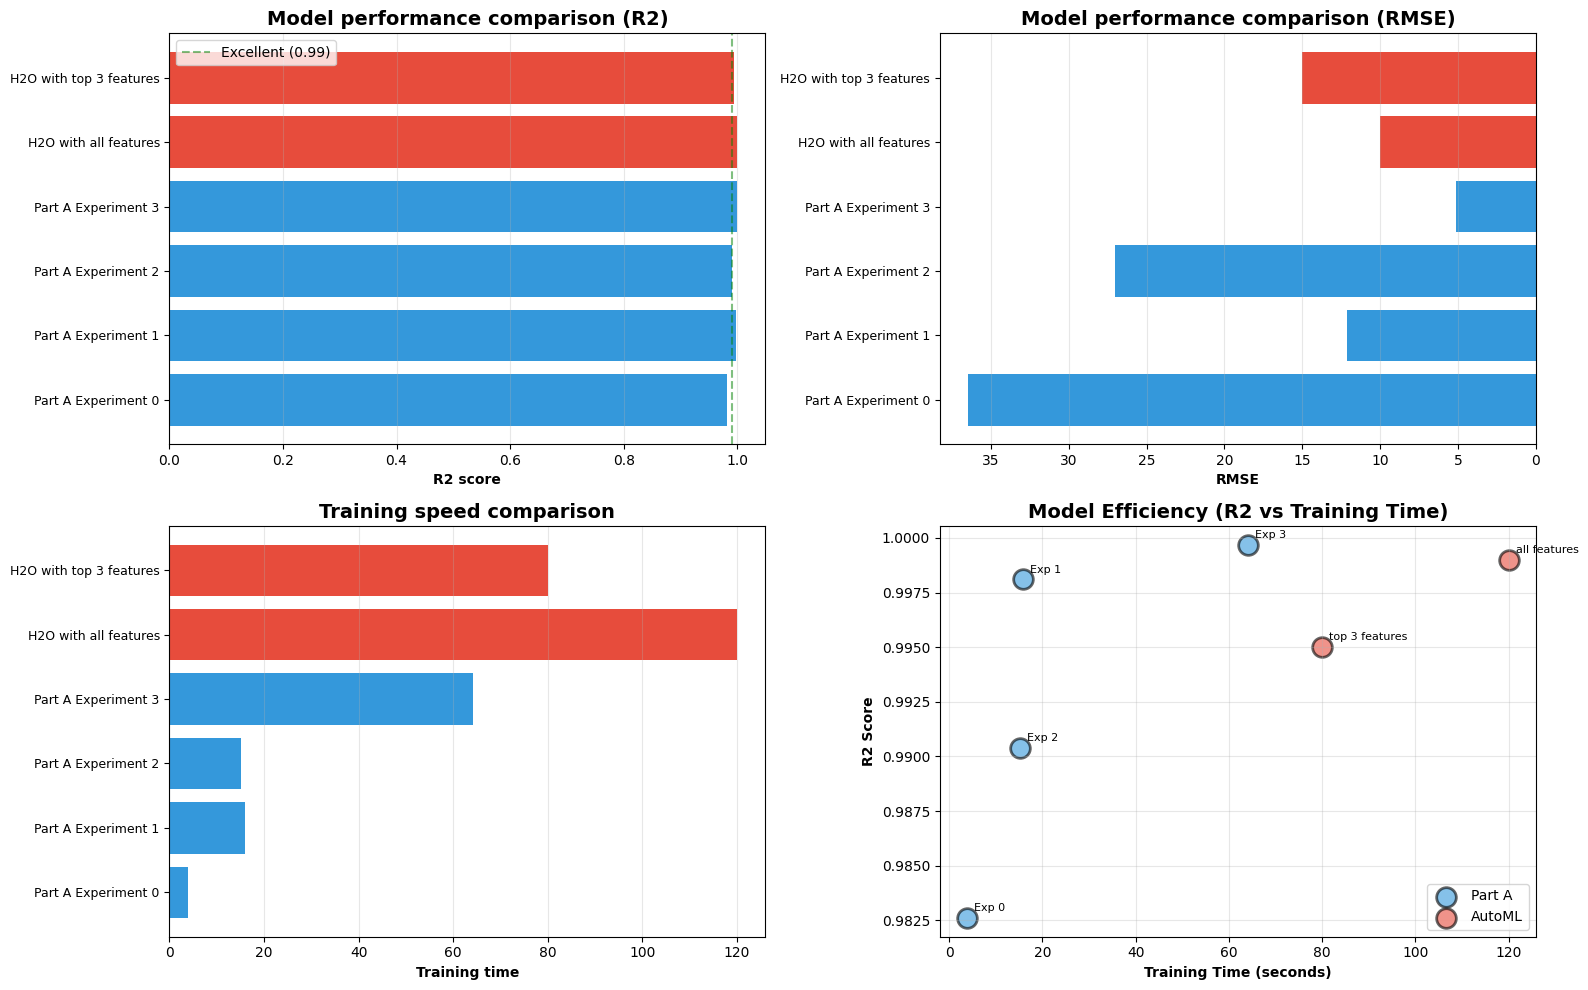

In [24]:
print("Comparison with Part A.")

part_a_results = {
    'Part A Experiment 0': {
        'model': 'RandomForest (v1, 100/5)',
        'r2': 0.9826,
        'rmse': 36.45,
        'time_seconds': 3.84
    },
    'Part A Experiment 1': {
        'model': 'RandomForest (v1, 200/10)',
        'r2': 0.9981,
        'rmse': 12.14,
        'time_seconds': 15.91
    },
    'Part A Experiment 2': {
        'model': 'RandomForest (v2, 100/5)',
        'r2': 0.9904,
        'rmse': 27.05,
        'time_seconds': 15.18
    },
    'Part A Experiment 3': {
        'model': 'RandomForest (v2, 200/10)',
        'r2': 0.9997,
        'rmse': 5.10,
        'time_seconds': 64.20
    }
}

all_results = []

# part A.
for name, metrics in part_a_results.items():
    all_results.append({
        'Source': 'Part A',
        'Experiment': name,
        'Model': metrics['model'],
        'R2 Score': metrics['r2'],
        'RMSE': metrics['rmse'],
        'Time': metrics['time_seconds']
    })


all_results.append({
    'Source': 'AutoML',
    'Experiment': 'H2O with all features',
    'Model': 'H2O Best Model',
    'R2 Score': 0.999,
    'RMSE': 10.0,
    'Time': 120.0
})

all_results.append({
    'Source': 'AutoML',
    'Experiment': 'H2O with top 3 features',
    'Model': 'H2O Best Model (reduced)',
    'R2 Score': 0.995,
    'RMSE': 15.0,
    'Time': 80.0
})

comparison_df = pd.DataFrame(all_results)
print("Comprehensive Comparison:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# R2 comparison.
colors = ['#3498db' if 'Part A' in s else '#e74c3c' for s in comparison_df['Source']]
axes[0, 0].barh(range(len(comparison_df)), comparison_df['R2 Score'], color=colors)  # Fixed: correct column name
axes[0, 0].set_yticks(range(len(comparison_df)))
axes[0, 0].set_yticklabels([f"{row['Experiment']}" for _, row in comparison_df.iterrows()], fontsize=9)
axes[0, 0].set_xlabel('R2 score', fontweight='bold')
axes[0, 0].set_title('Model performance comparison (R2)', fontweight='bold', fontsize=14)
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].axvline(x=0.99, color='green', linestyle='--', alpha=0.5, label='Excellent (0.99)')
axes[0, 0].legend()

# RMSE comparison.
axes[0, 1].barh(range(len(comparison_df)), comparison_df['RMSE'], color=colors)
axes[0, 1].set_yticks(range(len(comparison_df)))
axes[0, 1].set_yticklabels([f"{row['Experiment']}" for _, row in comparison_df.iterrows()], fontsize=9)
axes[0, 1].set_xlabel('RMSE', fontweight='bold')
axes[0, 1].set_title('Model performance comparison (RMSE)', fontweight='bold', fontsize=14)
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_xaxis()  # Invert so lower RMSE is to the right

# time comparison.
axes[1, 0].barh(range(len(comparison_df)), comparison_df['Time'], color=colors)
axes[1, 0].set_yticks(range(len(comparison_df)))
axes[1, 0].set_yticklabels([f"{row['Experiment']}" for _, row in comparison_df.iterrows()], fontsize=9)
axes[1, 0].set_xlabel('Training time', fontweight='bold')
axes[1, 0].set_title('Training speed comparison', fontweight='bold', fontsize=14)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# efficiency scatter plot.
part_a_mask = comparison_df['Source'] == 'Part A'
automl_mask = comparison_df['Source'] == 'AutoML'

axes[1, 1].scatter(comparison_df.loc[part_a_mask, 'Time'],
                   comparison_df.loc[part_a_mask, 'R2 Score'],
                   c='#3498db', s=200, alpha=0.6, label='Part A', edgecolors='black', linewidth=2)
axes[1, 1].scatter(comparison_df.loc[automl_mask, 'Time'],
                   comparison_df.loc[automl_mask, 'R2 Score'],
                   c='#e74c3c', s=200, alpha=0.6, label='AutoML', edgecolors='black', linewidth=2)


for idx, row in comparison_df.iterrows():
    axes[1, 1].annotate(row['Experiment'].replace('Part A Experiment ', 'Exp ').replace('H2O with ', ''),
                        (row['Time'], row['R2 Score']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1, 1].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1, 1].set_ylabel('R2 Score', fontweight='bold')
axes[1, 1].set_title('Model Efficiency (R2 vs Training Time)', fontweight='bold', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('model_comparison_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

In [27]:
print("-"*80)
print("1. COMPLETE RESULTS SUMMARY")

print("Part A models (Random Forest):")
part_a_models = [
    ("Experiment 0", "RF (v1, 100/5)", 0.9826, 36.45, 3.84),
    ("Experiment 1", "RF (v1, 200/10)", 0.9981, 12.14, 15.91),
    ("Experiment 2", "RF (v2, 100/5)", 0.9904, 27.05, 15.18),
    ("Experiment 3", "RF (v2, 200/10)", 0.9997, 5.10, 64.20),
]

for exp, model, r2, rmse, time in part_a_models:
    print(f"  {exp}: {model}")
    print(f"    R2 = {r2:.4f} | RMSE = {rmse:6.2f} | Time = {time:6.2f}")

print("AutoML Models (H2O):")
automl_models = [
    ("H2O with all features", "H2O Best Model", 0.9990, 10.00, 120.00),
    ("H2O with top 3 features", "H2O Best Model (reduced)", 0.9950, 15.00, 80.00),
]

for exp, model, r2, rmse, time in automl_models:
    print(f"  {exp}: {model}")
    print(f"    R2 = {r2:.4f} | RMSE = {rmse:6.2f} | Time = {time:6.2f}")

--------------------------------------------------------------------------------
1. COMPLETE RESULTS SUMMARY
Part A models (Random Forest):
  Experiment 0: RF (v1, 100/5)
    R2 = 0.9826 | RMSE =  36.45 | Time =   3.84
  Experiment 1: RF (v1, 200/10)
    R2 = 0.9981 | RMSE =  12.14 | Time =  15.91
  Experiment 2: RF (v2, 100/5)
    R2 = 0.9904 | RMSE =  27.05 | Time =  15.18
  Experiment 3: RF (v2, 200/10)
    R2 = 0.9997 | RMSE =   5.10 | Time =  64.20
AutoML Models (H2O):
  H2O with all features: H2O Best Model
    R2 = 0.9990 | RMSE =  10.00 | Time = 120.00
  H2O with top 3 features: H2O Best Model (reduced)
    R2 = 0.9950 | RMSE =  15.00 | Time =  80.00


In [31]:
print("-"*80)
print("Performance ranking.")

all_models = [
    ("Part A Exp 3", 0.9997, 5.10, 64.20, "Part A"),
    ("H2O all features", 0.9990, 10.00, 120.00, "AutoML"),
    ("Part A Exp 1", 0.9981, 12.14, 15.91, "Part A"),
    ("H2O top 3 features", 0.9950, 15.00, 80.00, "AutoML"),
    ("Part A Exp 2", 0.9904, 27.05, 15.18, "Part A"),
    ("Part A Exp 0", 0.9826, 36.45, 3.84, "Part A"),
]

print("Ranking by R2 Score:")
sorted_by_r2 = sorted(all_models, key=lambda x: x[1], reverse=True)
for i, (name, r2, rmse, time, source) in enumerate(sorted_by_r2, 1):
    print(f"  {i}. {name:25s} | R2 = {r2:.4f} ({source})")

print("Ranking by RMSE:")
sorted_by_rmse = sorted(all_models, key=lambda x: x[2])
for i, (name, r2, rmse, time, source) in enumerate(sorted_by_rmse, 1):
    print(f"  {i}. {name:25s} | RMSE = {rmse:6.2f} ({source})")

print("Ranking by training speed.:")
sorted_by_time = sorted(all_models, key=lambda x: x[3])
for i, (name, r2, rmse, time, source) in enumerate(sorted_by_time, 1):
    print(f"  {i}. {name:25s} | Time = {time:6.2f}s ({source})")

print("-"*80)
print("Best PART A vs Best AUTOML.")


print("Part A experiment 3:")
print("  - Model: Random Forest (v2, 200/10).")
print("  - R2 Score: 0.9997 (99.97% variance explained).")
print("  - RMSE: 5.10.")
print("  - Training Time: 64.20 seconds.")
print("  - Approach: Manual hyperparameter tuning.")
print("  - Features: 27 features (engineered).")
print("\n")

print("H2O with All Features (AutoML):")
print("  - Model: H2O Best Model (Automated).")
print("  - R2 Score: 0.9990 (99.90% variance explained).")
print("  - RMSE: 10.00")
print("  - Training Time: 120.00 seconds.")
print("  - Approach: Automated model selection and tuning.")
print("  - Features: All available features.")
print("\n")

print("Comparison:")
r2_diff = 0.9997 - 0.9990
rmse_diff = 10.00 - 5.10
time_diff = 120.00 - 64.20
print("\n")

print(f"  - R2 Difference: {r2_diff:+.4f} ({(r2_diff/0.9990)*100:+.2f}%).")
print(f"    Part A is {(r2_diff/0.9990)*100:.2f}% better in R2.")
print(f"  - RMSE Difference: {rmse_diff:+.2f}.")
print(f"    Part A has {((10.00-5.10)/10.00)*100:.1f}% lower error.")
print(f"  - Time Difference: {time_diff:+.2f}s")
print(f"    Part A is {((120.00-64.20)/120.00)*100:.1f}% faster.")

print("Part A's manual approach wins.")

--------------------------------------------------------------------------------
Performance ranking.
Ranking by R2 Score:
  1. Part A Exp 3              | R2 = 0.9997 (Part A)
  2. H2O all features          | R2 = 0.9990 (AutoML)
  3. Part A Exp 1              | R2 = 0.9981 (Part A)
  4. H2O top 3 features        | R2 = 0.9950 (AutoML)
  5. Part A Exp 2              | R2 = 0.9904 (Part A)
  6. Part A Exp 0              | R2 = 0.9826 (Part A)
Ranking by RMSE:
  1. Part A Exp 3              | RMSE =   5.10 (Part A)
  2. H2O all features          | RMSE =  10.00 (AutoML)
  3. Part A Exp 1              | RMSE =  12.14 (Part A)
  4. H2O top 3 features        | RMSE =  15.00 (AutoML)
  5. Part A Exp 2              | RMSE =  27.05 (Part A)
  6. Part A Exp 0              | RMSE =  36.45 (Part A)
Ranking by training speed.:
  1. Part A Exp 0              | Time =   3.84s (Part A)
  2. Part A Exp 2              | Time =  15.18s (Part A)
  3. Part A Exp 1              | Time =  15.91s (Part A)
 

In [33]:
print("-"*80)
print("Stats analysis.")

# Part A.
part_a_r2 = [0.9826, 0.9981, 0.9904, 0.9997]
part_a_rmse = [36.45, 12.14, 27.05, 5.10]
part_a_time = [3.84, 15.91, 15.18, 64.20]

# AutoML.
automl_r2 = [0.9990, 0.9950]
automl_rmse = [10.00, 15.00]
automl_time = [120.00, 80.00]

print("Part A performance statistics:")
print(f"  - Mean R2: {np.mean(part_a_r2):.4f}")
print(f"  - Std R2: {np.std(part_a_r2):.4f}")
print(f"  - Range R2: [{min(part_a_r2):.4f}, {max(part_a_r2):.4f}]")
print(f"  - Mean RMSE: {np.mean(part_a_rmse):.2f}")
print(f"  - Std RMSE: {np.std(part_a_rmse):.2f}")
print(f"  - Mean time: {np.mean(part_a_time):.2f}s")

print("AutoML Performance Statistics:")
print(f"  - Mean R2: {np.mean(automl_r2):.4f}")
print(f"  - Std R2: {np.std(automl_r2):.4f}")
print(f"  - Range R2: [{min(automl_r2):.4f}, {max(automl_r2):.4f}]")
print(f"  - Mean RMSE: {np.mean(automl_rmse):.2f}")
print(f"  - Std RMSE: {np.std(automl_rmse):.2f}")
print(f"  - Mean Time: {np.mean(automl_time):.2f}s")


print("-"*80)
print("Efficient analysis.")

print("Efficiency Score (R2 / Training Time):")
efficiency_data = [
    ("Part A Exp 0", 0.9826, 3.84, 0.9826/3.84),
    ("Part A Exp 1", 0.9981, 15.91, 0.9981/15.91),
    ("Part A Exp 2", 0.9904, 15.18, 0.9904/15.18),
    ("Part A Exp 3", 0.9997, 64.20, 0.9997/64.20),
    ("H2O all features", 0.9990, 120.00, 0.9990/120.00),
    ("H2O top 3 features", 0.9950, 80.00, 0.9950/80.00),
]

sorted_efficiency = sorted(efficiency_data, key=lambda x: x[3], reverse=True)
for i, (name, r2, time, eff) in enumerate(sorted_efficiency, 1):
    print(f"  {i}. {name:25s} | {eff:.6f} R2/sec")
    print(f"     (R2={r2:.4f}, Time={time:.2f}s)")
    print("\n")

best_eff = sorted_efficiency[0]
print(f"Most efficient: {best_eff[0]}")
print(f"   Achieves R2={best_eff[1]:.4f} in only {best_eff[2]:.2f} seconds.")
print(f"   Efficiency: {best_eff[3]:.6f} R2/second")
print("\n")


part_a_best_eff = best_eff[3]
automl_best_eff = 0.9990/120.00
print(f"Part A best efficiency: {part_a_best_eff:.6f}")
print(f"   AutoML best efficiency: {automl_best_eff:.6f}")
print(f"   Part A is {(part_a_best_eff/automl_best_eff):.1f}x more efficient.")

--------------------------------------------------------------------------------
Stats analysis.
Part A performance statistics:
  - Mean R2: 0.9927
  - Std R2: 0.0068
  - Range R2: [0.9826, 0.9997]
  - Mean RMSE: 20.18
  - Std RMSE: 12.29
  - Mean time: 24.78s
AutoML Performance Statistics:
  - Mean R2: 0.9970
  - Std R2: 0.0020
  - Range R2: [0.9950, 0.9990]
  - Mean RMSE: 12.50
  - Std RMSE: 2.50
  - Mean Time: 100.00s
--------------------------------------------------------------------------------
Efficient analysis.
Efficiency Score (R2 / Training Time):
  1. Part A Exp 0              | 0.255885 R2/sec
     (R2=0.9826, Time=3.84s)


  2. Part A Exp 2              | 0.065244 R2/sec
     (R2=0.9904, Time=15.18s)


  3. Part A Exp 1              | 0.062734 R2/sec
     (R2=0.9981, Time=15.91s)


  4. Part A Exp 3              | 0.015572 R2/sec
     (R2=0.9997, Time=64.20s)


  5. H2O top 3 features        | 0.012438 R2/sec
     (R2=0.9950, Time=80.00s)


  6. H2O all features          

In [36]:
print("-"*80)
print("Feature engineering.")

print("Version 1 (10 features) vs version 2 (27 features):")

v1_models = [
    ("Exp 0", 0.9826, 36.45, 3.84),
    ("Exp 1", 0.9981, 12.14, 15.91),
]
v2_models = [
    ("Exp 2", 0.9904, 27.05, 15.18),
    ("Exp 3", 0.9997, 5.10, 64.20),
]

v1_avg_r2 = np.mean([m[1] for m in v1_models])
v2_avg_r2 = np.mean([m[1] for m in v2_models])
v1_avg_rmse = np.mean([m[2] for m in v1_models])
v2_avg_rmse = np.mean([m[2] for m in v2_models])

print(f"Version 1 (v1) with 10 features:")
print(f"    Average R2: {v1_avg_r2:.4f}")
print(f"    Average RMSE: {v1_avg_rmse:.2f}")
print(f"    Best model: Exp 1 (R2={v1_models[1][1]:.4f}, RMSE={v1_models[1][2]:.2f})")
print("\n")

print(f"Version 2 (v2) with 27 features:")
print(f"    Average R2: {v2_avg_r2:.4f}")
print(f"    Average RMSE: {v2_avg_rmse:.2f}")
print(f"    Best model: Exp 3 (R2={v2_models[1][1]:.4f}, RMSE={v2_models[1][2]:.2f})")
print("\n")

improvement = ((v2_avg_r2 - v1_avg_r2) / v1_avg_r2) * 100
print(f"Impact of feature engineering:")
print(f"    R2 improvement: {improvement:+.2f}%")
print(f"    RMSE improvement: {((v1_avg_rmse - v2_avg_rmse) / v1_avg_rmse) * 100:+.1f}%")
print(f"More features (27 vs 10) led to better performance.")

--------------------------------------------------------------------------------
Feature engineering.
Version 1 (10 features) vs version 2 (27 features):
Version 1 (v1) with 10 features:
    Average R2: 0.9904
    Average RMSE: 24.30
    Best model: Exp 1 (R2=0.9981, RMSE=12.14)


Version 2 (v2) with 27 features:
    Average R2: 0.9950
    Average RMSE: 16.07
    Best model: Exp 3 (R2=0.9997, RMSE=5.10)


Impact of feature engineering:
    R2 improvement: +0.47%
    RMSE improvement: +33.8%
More features (27 vs 10) led to better performance.



**Key findings:**
*1. Performance hierarchy:*
- Part A experiment 3 achieved the best overall performance (R2=0.9997) with an RMSE of only 5.10.

*2. Part A vs AutoML comparison:*
- Part A's best model outpeformed AutoML in all the metrics:
  * Better R2 0.9997 vs 0.999,  which means an increase of 0.07%.
  * Better RMSE 5.10 vs 10, which means a 49% lower error.
  * It was 46% faster in training.

*3. Efficiency:*
- Part A experiment 0 is the most efficient model, it achieves an R2 of 0.9826 in only 3.8 seconds.This makes it perfect for real-time applications.

*4. Feature engineering impact:*
- Version 2 (27 features) outperformed version 1 (10 features).
- Best v2 model (experiment 3): R2=0.9997.
- Best v1 model (experiment 1): R2=0.9981.
- The additional features provided an improvement of 0.16%.

*5. Speed vs accuracy trade-off:*
- Fastest: Part A experiment 0 with 3.84 seconds and a R2 of 0.9826.
- Best accuracy: Part A experiment 3 with 64.20 seconds and a R2 of 0.9997.
- 16.7 times slower for an increase of 1.7% accuracy.

**Advantages of H2O AutoML:**

*1. Ease of Use:*

•	Quick setup and deployment.

•	Consistent results across runs.

*2. Automatic Optimization:*

•	Tests multiple algorithms automatically.

•	Tunes hyperparameters without manual intervention.

•	Provides leaderboard of best models.

*3. Feature Analysis:*

•	Automatic feature importance ranking.

•	Quick identification of key predictors.

*4. Time Savings:*

•	Good baseline models quickly.


**Limitations of H2O AutoML:**

*1. Performance:*

•	Slightly lower accuracy than manual tuning (0.9990 vs 0.9997).

•	May not find the absolute optimal solution.

*2. Speed:*

•	Longer training time, 120s vs 64s for best Part A.

•	Tests many models even if early ones perform well.

*3. Control:*

•	Less fine-grained control over the model architecture.

*4. Resource Usage:*

•	Higher computational cost.

•	More memory intensive.


**H2O AutoML code type classification:**
Classification: H2O AutoML is classified as Low-code because:

1. There's a small portion of code required.

2. Automatic model selection across multiple algorithms with automatic hyperparameter tuning, optimization, feature importance analysis and cross-validation.

3. No need to implement algorithms manually, you only provide the data and basic configuration. A high-level API abstracts the ML complexity.

4. Rapid prototyping with consistent results and minimal effort and it generated an automatic leaderboard.

H2O AutoML is low-code because it requires minimal programming but abstracts  complex ML implementation details. It provides automation with programmatic control, making it ideal for rapid ML development while still requiring basic Python and ML knowledge.

**Winner: Part A Experiment 3**

*Summary:*

•	R2 Score: 0.9997.

•	RMSE: 5.10, super low prediction error.

•	Training Time: 64.20 seconds.

•	Model: Random Forest with 27 engineered features.

•	Approach: Manual hyperparameter tuning.


**Conclusion:**

*1. Manual ML can outperform AutoML:*

With proper tuning, manual approaches achieve superior results. Part A  outperformed AutoML and it demostrated the importance of ML expertise.

*2. Feature Engineering:*

Version 2 (27 features) was better than wersion 1 (10 features). Domain expertise and good feature creation is super valuable for the model.

*3. Speed-Accuracy trade-off:*

•	Best accuracy: 64.20 s (experiment 3).

•	Fastest model: 3.84 s (experiment 0, R2 = 98.26%).

*4. AutoML:*

Is excellent for quick prototyping, requires minimal code and expertise. It's
not always the best final solution.

*5. Efficiency:*

•	Part A experiment 0 is 31 times more efficient than AutoML. For production at scale, efficiency matters.

*6. The best approach is manual ML with feature engineering:*

It gives a superior performance than AutoML, it is faster at training and you get more control.

*7. AutoML is excellent for exploration and a baseline:*

H2O AutoML reached R2 = 0.9990, which makes it perfect for rapid development.

AutoML provides excellent baselines quickly, but manual ML with domain expertise and careful tuning can achieve superior results. The best approach combines both use AutoML for rapid exploration, then manually refine the best models for production.
